In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv

# **VEST MT 2020**

## **VEST Documentation**

#### Election Results

**sources**

Election results from Montana Secretary of State (https://sosmt.gov/elections/results/)

### Shapefiles

**sources**

Precinct shapefile primarily from Dave Ritts at the Montana State Library, as prepared for submission to the U.S. Census Bureau's 2020 Redistricting Data Program.

**Processing**

The three precincts in Treasure County were merged as the county transitioned to a single countywide precinct prior to the 2020 election.

## Candidates

G20PRERTRU - Donald J. Trump (Republican Party)
G20PREDBID - Joseph R. Biden (Democratic Party)
G20PRELJOR - Jo Jorgensen (Libertarian Party)

G20USSRDAI - Steve Daines (Republican Party)
G20USSDBUL - Steve Bullock (Democratic Party)

G20HALRROS - Matt Rosendale (Republican Party)
G20HALDWIL - Kathleen Williams (Democratic Party)

G20GOVRGIA - Greg Gianforte (Republican Party)
G20GOVDCOO - Mike Cooney (Democratic Party)
G20GOVLBIS - Lyman Bishop (Libertarian Party)

G20ATGRKNU - Austin Knudsen (Republican Party)
G20ATGDGRA - Raph Graybill (Democratic Party)

G20SOSRJAC - Christi Jacobsen (Republican Party)
G20SOSDBEN - Bryce Bennett (Democratic Party)

G20AUDRDOW - Troy Downing (Republican Party)
G20AUDDMOR - Shane A. Morigeau (Democratic Party)
G20AUDLROO - Roger Roots (Libertarian Party)

G20SPIRARN - Elsie Arntzen (Republican Party)
G20SPIDROM - Melissa Romano (Democratic Party)
G20SPILLEA - Kevin Leatherbarrow (Libertarian Party)


# **Election Result Processing**

## **Get VEST file and FIPS dictionary read**

### **Load in VEST file**

In [2]:
vest_mt_20 = gp.read_file("./raw-from-source/VEST/mt_2020/mt_2020.shp")

# **Load and Clean Election Results**
## **Load Election Results**

Created 2020-GeneralPrecinct-by-Precinct_Votes.csv from 2020-GeneralPrecinct-by-Precinct_Votes.xlsx by opening in Excel, removing the first header row, and saving as a csv. No file modifications were made.


In [3]:
elections_2020 = pd.read_csv("./raw-from-source/MT_SOS/2020_General_Precinct-by-Precinct.csv")

In [4]:
elections_2020.shape

(29386, 8)

In [5]:
elections_2020.head()

,CountyName,PrecinctName,RaceName,PartyCode,Votes,NameOnBallot,HouseDistrict,SenateDistrict
0,Beaverhead,PRECINCT 01,PRESIDENT,DEM,166,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36
1,Beaverhead,PRECINCT 02,PRESIDENT,DEM,181,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36
2,Beaverhead,PRECINCT 03,PRESIDENT,DEM,227,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36
3,Beaverhead,PRECINCT 04,PRESIDENT,DEM,34,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36
4,Beaverhead,PRECINCT 05,PRESIDENT,DEM,24,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36


## **Prepare to Pivot Election Results**

In [6]:
#Filter down to offices we need
office_list = ['PRESIDENT','UNITED STATES SENATOR','UNITED STATES REPRESENTATIVE','GOVERNOR & LT. GOVERNOR','ATTORNEY GENERAL','SECRETARY OF STATE','STATE AUDITOR','STATE SUPERINTENDENT OF PUBLIC INSTRUCTION']
elections_2020 = elections_2020[elections_2020["RaceName"].isin(office_list)]

In [7]:
#Filter a list of candidates we need based on VEST's file
candidate_list = ['DONALD J. TRUMP AND MICHAEL R. PENCE','JOSEPH R. BIDEN AND KAMALA D. HARRIS','JO JORGENSEN AND JEREMY "SPIKE" COHEN','STEVE DAINES','STEVE BULLOCK','MATT ROSENDALE','KATHLEEN WILLIAMS','GREG GIANFORTE AND KRISTEN JURAS','MIKE COONEY AND CASEY SCHREINER','LYMAN BISHOP AND JOHN NESPER','AUSTIN KNUDSEN','RAPH GRAYBILL','CHRISTI JACOBSEN','BRYCE BENNETT','TROY DOWNING','SHANE A MORIGEAU','ROGER ROOTS','ELSIE ARNTZEN','MELISSA ROMANO','KEVIN LEATHERBARROW']

#Filter the file down by candidate list
elections_2020=elections_2020[elections_2020["NameOnBallot"].isin([x.upper() for x in candidate_list])]

In [8]:
elections_2020["NameOnBallot"].unique()

array(['JOSEPH R. BIDEN AND KAMALA D. HARRIS',
       'JO JORGENSEN AND JEREMY "SPIKE" COHEN',
       'DONALD J. TRUMP AND MICHAEL R. PENCE', 'STEVE BULLOCK',
       'STEVE DAINES', 'KATHLEEN WILLIAMS', 'MATT ROSENDALE',
       'MIKE COONEY AND CASEY SCHREINER', 'LYMAN BISHOP AND JOHN NESPER',
       'GREG GIANFORTE AND KRISTEN JURAS', 'BRYCE BENNETT',
       'CHRISTI JACOBSEN', 'RAPH GRAYBILL', 'AUSTIN KNUDSEN',
       'SHANE A MORIGEAU', 'ROGER ROOTS', 'TROY DOWNING',
       'MELISSA ROMANO', 'KEVIN LEATHERBARROW', 'ELSIE ARNTZEN'],
      dtype=object)

In [9]:
elections_2020.shape

(13260, 8)

## **Create a FIPS dicionary for MT**

In [10]:
#Load the nationwide FIPS file and filter by Montana
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Montana"]

#Make the FIPS three digits
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))

In [11]:
#Add FIPS columns
elections_2020["COUNTYFP10"]=elections_2020["CountyName"].map(fips_dict).fillna(elections_2020["CountyName"])

#Check that FIPS counties matched
elections_2020["COUNTYFP10"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', 'Lewis & Clark', '051',
       '053', '057', '055', '059', '061', '063', '065', '067', '069',
       '071', '073', '075', '077', '079', '081', '083', '085', '087',
       '089', '091', '093', '095', '097', '099', '101', '103', '105',
       '107', '109', '111'], dtype=object)

In [12]:
#Change any column names to match FIPS dictionary
elections_2020.loc[elections_2020['CountyName'] == 'Lewis & Clark', 'CountyName'] = 'Lewis and Clark'

#Retry adding FIPS column and check results
elections_2020["COUNTYFP10"]=elections_2020["CountyName"].map(fips_dict).fillna(elections_2020["CountyName"])
elections_2020["COUNTYFP10"].unique()

array(['001', '003', '005', '007', '009', '011', '013', '015', '017',
       '019', '021', '023', '025', '027', '029', '031', '033', '035',
       '037', '039', '041', '043', '045', '047', '049', '051', '053',
       '057', '055', '059', '061', '063', '065', '067', '069', '071',
       '073', '075', '077', '079', '081', '083', '085', '087', '089',
       '091', '093', '095', '097', '099', '101', '103', '105', '107',
       '109', '111'], dtype=object)

In [13]:
print(elections_2020["CountyName"].nunique())
print(len(fips_dict))

56
56


In [14]:
elections_2020.head()

,CountyName,PrecinctName,RaceName,PartyCode,Votes,NameOnBallot,HouseDistrict,SenateDistrict,COUNTYFP10
0,Beaverhead,PRECINCT 01,PRESIDENT,DEM,166,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36,001
1,Beaverhead,PRECINCT 02,PRESIDENT,DEM,181,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36,001
2,Beaverhead,PRECINCT 03,PRESIDENT,DEM,227,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36,001
3,Beaverhead,PRECINCT 04,PRESIDENT,DEM,34,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36,001
4,Beaverhead,PRECINCT 05,PRESIDENT,DEM,24,JOSEPH R. BIDEN AND KAMALA D. HARRIS,House District 72,Senate District 36,001


In [15]:
#Clean up precinct column by stripping the white space
elections_2020["PrecinctName"]=elections_2020["PrecinctName"].str.strip()

#Create a column to pivot table by concatenation the FIPS and precinct columns
elections_2020["pivot_col"]=elections_2020["COUNTYFP10"]+elections_2020["PrecinctName"]

## **Pivot Election Results**

In [16]:
#Run the pivot
pivoted_2020 = pd.pivot_table(elections_2020,values=["Votes"],index=["pivot_col"],columns=["NameOnBallot"],aggfunc=sum)

#Fill in N/A with 0
pivoted_2020 = pivoted_2020.fillna(0)

#Clean the columns
pivoted_2020.reset_index(drop=False,inplace=True)
pivoted_2020.columns = pivoted_2020.columns.droplevel(0)

In [17]:
#Print to get an idea of the pivoted df
pivoted_2020.head()

NameOnBallot,,AUSTIN KNUDSEN,BRYCE BENNETT,CHRISTI JACOBSEN,DONALD J. TRUMP AND MICHAEL R. PENCE,ELSIE ARNTZEN,GREG GIANFORTE AND KRISTEN JURAS,"JO JORGENSEN AND JEREMY ""SPIKE"" COHEN",JOSEPH R. BIDEN AND KAMALA D. HARRIS,KATHLEEN WILLIAMS,...,LYMAN BISHOP AND JOHN NESPER,MATT ROSENDALE,MELISSA ROMANO,MIKE COONEY AND CASEY SCHREINER,RAPH GRAYBILL,ROGER ROOTS,SHANE A MORIGEAU,STEVE BULLOCK,STEVE DAINES,TROY DOWNING
0,001PRECINCT 01,198,161,205,192,173,190,15,166,177,...,19,196,172,167,171,25,158,187,188,186
1,001PRECINCT 02,668,169,681,671,617,627,12,181,213,...,31,646,204,201,191,45,171,222,645,634
2,001PRECINCT 03,626,211,638,625,589,621,17,227,250,...,17,615,241,225,227,35,209,246,627,599
3,001PRECINCT 04,181,35,177,181,163,168,6,34,43,...,8,176,49,43,35,13,27,46,175,175
4,001PRECINCT 05,124,21,125,120,111,117,5,24,29,...,2,120,29,32,22,12,20,30,119,114


In [18]:
pivoted_2020.rename(columns={ pivoted_2020.columns[0]: "join_col" }, inplace = True)
pivoted_2020.head()

NameOnBallot,join_col,AUSTIN KNUDSEN,BRYCE BENNETT,CHRISTI JACOBSEN,DONALD J. TRUMP AND MICHAEL R. PENCE,ELSIE ARNTZEN,GREG GIANFORTE AND KRISTEN JURAS,"JO JORGENSEN AND JEREMY ""SPIKE"" COHEN",JOSEPH R. BIDEN AND KAMALA D. HARRIS,KATHLEEN WILLIAMS,...,LYMAN BISHOP AND JOHN NESPER,MATT ROSENDALE,MELISSA ROMANO,MIKE COONEY AND CASEY SCHREINER,RAPH GRAYBILL,ROGER ROOTS,SHANE A MORIGEAU,STEVE BULLOCK,STEVE DAINES,TROY DOWNING
0,001PRECINCT 01,198,161,205,192,173,190,15,166,177,...,19,196,172,167,171,25,158,187,188,186
1,001PRECINCT 02,668,169,681,671,617,627,12,181,213,...,31,646,204,201,191,45,171,222,645,634
2,001PRECINCT 03,626,211,638,625,589,621,17,227,250,...,17,615,241,225,227,35,209,246,627,599
3,001PRECINCT 04,181,35,177,181,163,168,6,34,43,...,8,176,49,43,35,13,27,46,175,175
4,001PRECINCT 05,124,21,125,120,111,117,5,24,29,...,2,120,29,32,22,12,20,30,119,114


In [19]:
#Add FIPS State and County columns
pivoted_2020.insert(loc=0, column='STATEFP10', value='30')
pivoted_2020.insert(loc=1, column='COUNTYFP10', value=pivoted_2020['join_col'].str[0:3])

#Add County and SOSPRECINC columns
inv_dict = {v: k for k, v in fips_dict.items()}
pivoted_2020.insert(loc=2, column='COUNTY', value=elections_2020["COUNTYFP10"].map(inv_dict))
pivoted_2020.insert(loc=3, column='SOSPRECINC', value=pivoted_2020['join_col'].str[3:])


In [20]:
pivoted_2020.head()

NameOnBallot,STATEFP10,COUNTYFP10,COUNTY,SOSPRECINC,join_col,AUSTIN KNUDSEN,BRYCE BENNETT,CHRISTI JACOBSEN,DONALD J. TRUMP AND MICHAEL R. PENCE,ELSIE ARNTZEN,...,LYMAN BISHOP AND JOHN NESPER,MATT ROSENDALE,MELISSA ROMANO,MIKE COONEY AND CASEY SCHREINER,RAPH GRAYBILL,ROGER ROOTS,SHANE A MORIGEAU,STEVE BULLOCK,STEVE DAINES,TROY DOWNING
0,30,001,Beaverhead,PRECINCT 01,001PRECINCT 01,198,161,205,192,173,...,19,196,172,167,171,25,158,187,188,186
1,30,001,Beaverhead,PRECINCT 02,001PRECINCT 02,668,169,681,671,617,...,31,646,204,201,191,45,171,222,645,634
2,30,001,Beaverhead,PRECINCT 03,001PRECINCT 03,626,211,638,625,589,...,17,615,241,225,227,35,209,246,627,599
3,30,001,Beaverhead,PRECINCT 04,001PRECINCT 04,181,35,177,181,163,...,8,176,49,43,35,13,27,46,175,175
4,30,001,Beaverhead,PRECINCT 05,001PRECINCT 05,124,21,125,120,111,...,2,120,29,32,22,12,20,30,119,114


In [21]:
#Look at VEST's file columns
vest_mt_20.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'NAME', 'SOSPRECINC', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20USSRDAI', 'G20USSDBUL', 'G20HALRROS',
       'G20HALDWIL', 'G20GOVRGIA', 'G20GOVDCOO', 'G20GOVLBIS', 'G20ATGRKNU',
       'G20ATGDGRA', 'G20SOSRJAC', 'G20SOSDBEN', 'G20AUDRDOW', 'G20AUDDMOR',
       'G20AUDLROO', 'G20SPIRARN', 'G20SPIDROM', 'G20SPILLEA', 'geometry'],
      dtype='object')

In [22]:
#Look at Election results columns
pivoted_2020.columns

Index(['STATEFP10', 'COUNTYFP10', 'COUNTY', 'SOSPRECINC', 'join_col',
       'AUSTIN KNUDSEN', 'BRYCE BENNETT', 'CHRISTI JACOBSEN',
       'DONALD J. TRUMP AND MICHAEL R. PENCE', 'ELSIE ARNTZEN',
       'GREG GIANFORTE AND KRISTEN JURAS',
       'JO JORGENSEN AND JEREMY "SPIKE" COHEN',
       'JOSEPH R. BIDEN AND KAMALA D. HARRIS', 'KATHLEEN WILLIAMS',
       'KEVIN LEATHERBARROW', 'LYMAN BISHOP AND JOHN NESPER', 'MATT ROSENDALE',
       'MELISSA ROMANO', 'MIKE COONEY AND CASEY SCHREINER', 'RAPH GRAYBILL',
       'ROGER ROOTS', 'SHANE A MORIGEAU', 'STEVE BULLOCK', 'STEVE DAINES',
       'TROY DOWNING'],
      dtype='object', name='NameOnBallot')

In [23]:
#Reorder Election results columns to match VEST's
pivoted_2020 = pivoted_2020[['STATEFP10', 'COUNTYFP10', 'COUNTY', 'SOSPRECINC', 'DONALD J. TRUMP AND MICHAEL R. PENCE',
       'JOSEPH R. BIDEN AND KAMALA D. HARRIS', 'JO JORGENSEN AND JEREMY "SPIKE" COHEN', 'STEVE DAINES', 'STEVE BULLOCK', 'MATT ROSENDALE',
       'KATHLEEN WILLIAMS', 'GREG GIANFORTE AND KRISTEN JURAS', 'MIKE COONEY AND CASEY SCHREINER', 'LYMAN BISHOP AND JOHN NESPER', 'AUSTIN KNUDSEN',
       'RAPH GRAYBILL', 'CHRISTI JACOBSEN', 'BRYCE BENNETT', 'TROY DOWNING', 'SHANE A MORIGEAU',
       'ROGER ROOTS', 'ELSIE ARNTZEN', 'MELISSA ROMANO', 'KEVIN LEATHERBARROW', 'join_col']]
pivoted_2020.head()

NameOnBallot,STATEFP10,COUNTYFP10,COUNTY,SOSPRECINC,DONALD J. TRUMP AND MICHAEL R. PENCE,JOSEPH R. BIDEN AND KAMALA D. HARRIS,"JO JORGENSEN AND JEREMY ""SPIKE"" COHEN",STEVE DAINES,STEVE BULLOCK,MATT ROSENDALE,...,RAPH GRAYBILL,CHRISTI JACOBSEN,BRYCE BENNETT,TROY DOWNING,SHANE A MORIGEAU,ROGER ROOTS,ELSIE ARNTZEN,MELISSA ROMANO,KEVIN LEATHERBARROW,join_col
0,30,001,Beaverhead,PRECINCT 01,192,166,15,188,187,196,...,171,205,161,186,158,25,173,172,25,001PRECINCT 01
1,30,001,Beaverhead,PRECINCT 02,671,181,12,645,222,646,...,191,681,169,634,171,45,617,204,33,001PRECINCT 02
2,30,001,Beaverhead,PRECINCT 03,625,227,17,627,246,615,...,227,638,211,599,209,35,589,241,25,001PRECINCT 03
3,30,001,Beaverhead,PRECINCT 04,181,34,6,175,46,176,...,35,177,35,175,27,13,163,49,3,001PRECINCT 04
4,30,001,Beaverhead,PRECINCT 05,120,24,5,119,30,120,...,22,125,21,114,20,12,111,29,5,001PRECINCT 05


In [24]:
#Change Election results columns to match VEST's
pivoted_2020.columns = ['STATEFP10', 'COUNTYFP10', 'COUNTY', 'SOSPRECINC', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20USSRDAI', 'G20USSDBUL', 'G20HALRROS',
       'G20HALDWIL', 'G20GOVRGIA', 'G20GOVDCOO', 'G20GOVLBIS', 'G20ATGRKNU',
       'G20ATGDGRA', 'G20SOSRJAC', 'G20SOSDBEN', 'G20AUDRDOW', 'G20AUDDMOR',
       'G20AUDLROO', 'G20SPIRARN', 'G20SPIDROM', 'G20SPILLEA', 'join_col']

In [25]:
#Create a join column in the VEST file
vest_mt_20["join_col"]=vest_mt_20['COUNTYFP10']+vest_mt_20['SOSPRECINC']

In [26]:
print(vest_mt_20.shape)
pivoted_2020.shape

(666, 27)


(663, 25)

# **Compare Election Results Totals**

## **Compare Total Votes**

In [27]:
races = [x for x in vest_mt_20.columns if 'G20' in x]
races

['G20PRERTRU',
 'G20PREDBID',
 'G20PRELJOR',
 'G20USSRDAI',
 'G20USSDBUL',
 'G20HALRROS',
 'G20HALDWIL',
 'G20GOVRGIA',
 'G20GOVDCOO',
 'G20GOVLBIS',
 'G20ATGRKNU',
 'G20ATGDGRA',
 'G20SOSRJAC',
 'G20SOSDBEN',
 'G20AUDRDOW',
 'G20AUDDMOR',
 'G20AUDLROO',
 'G20SPIRARN',
 'G20SPIDROM',
 'G20SPILLEA']

In [28]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_mt_20[i])
    sum_var_2 += np.sum(pivoted_2020[i])
print(sum_var_1)
print(sum_var_2)

4787118
4787118


## **Compare Race Totals**

In [29]:
for race in races:
    diff_val = sum(vest_mt_20[race])-sum(pivoted_2020[race])
    if diff_val != 0:
        print(race+": "+str(diff_val))
    else:
        print(race+": EQUAL")

G20PRERTRU: EQUAL
G20PREDBID: EQUAL
G20PRELJOR: EQUAL
G20USSRDAI: EQUAL
G20USSDBUL: EQUAL
G20HALRROS: EQUAL
G20HALDWIL: EQUAL
G20GOVRGIA: EQUAL
G20GOVDCOO: EQUAL
G20GOVLBIS: EQUAL
G20ATGRKNU: EQUAL
G20ATGDGRA: EQUAL
G20SOSRJAC: EQUAL
G20SOSDBEN: EQUAL
G20AUDRDOW: EQUAL
G20AUDDMOR: EQUAL
G20AUDLROO: EQUAL
G20SPIRARN: EQUAL
G20SPIDROM: EQUAL
G20SPILLEA: EQUAL


## **Compare County Totals**

In [30]:
diff_counties=[]
for i in races:
    diff = pivoted_2020.groupby(["COUNTYFP10"]).sum()[i]-vest_mt_20.groupby(["COUNTYFP10"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(race, diff[diff != 0].to_string(header=False), 'NOT EQUAL')
    else:
        print(race + ' county totals: EQUAL')

G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL
G20SPILLEA county totals: EQUAL


## **Check for Zero Vote Precincts in VEST**

In [31]:
vest_mt_20[vest_mt_20['G20PRERTRU'] == 0]

,STATEFP10,COUNTYFP10,COUNTY,NAME,SOSPRECINC,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRDAI,G20USSDBUL,...,G20SOSRJAC,G20SOSDBEN,G20AUDRDOW,G20AUDDMOR,G20AUDLROO,G20SPIRARN,G20SPIDROM,G20SPILLEA,geometry,join_col
387,30,029,Flathead,NA,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-113.79807 48.22350, -113.79620 48.2...",NaN
388,30,029,Flathead,NA,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-113.79240 48.38270, -113.79256 48.3...",NaN
662,30,047,Lake,NA,None,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-114.03396 47.95345, -114.03355 47.9...",NaN


## **Attempt to join the dataframes**

In [32]:
join_attempt_one = pd.merge(vest_mt_20,pivoted_2020,how="outer",on="join_col",indicator=True)
print(join_attempt_one["_merge"].value_counts())

both          647
left_only      19
right_only     16
Name: _merge, dtype: int64


In [33]:
join_attempt_one.columns

Index(['STATEFP10_x', 'COUNTYFP10_x', 'COUNTY_x', 'NAME', 'SOSPRECINC_x',
       'G20PRERTRU_x', 'G20PREDBID_x', 'G20PRELJOR_x', 'G20USSRDAI_x',
       'G20USSDBUL_x', 'G20HALRROS_x', 'G20HALDWIL_x', 'G20GOVRGIA_x',
       'G20GOVDCOO_x', 'G20GOVLBIS_x', 'G20ATGRKNU_x', 'G20ATGDGRA_x',
       'G20SOSRJAC_x', 'G20SOSDBEN_x', 'G20AUDRDOW_x', 'G20AUDDMOR_x',
       'G20AUDLROO_x', 'G20SPIRARN_x', 'G20SPIDROM_x', 'G20SPILLEA_x',
       'geometry', 'join_col', 'STATEFP10_y', 'COUNTYFP10_y', 'COUNTY_y',
       'SOSPRECINC_y', 'G20PRERTRU_y', 'G20PREDBID_y', 'G20PRELJOR_y',
       'G20USSRDAI_y', 'G20USSDBUL_y', 'G20HALRROS_y', 'G20HALDWIL_y',
       'G20GOVRGIA_y', 'G20GOVDCOO_y', 'G20GOVLBIS_y', 'G20ATGRKNU_y',
       'G20ATGDGRA_y', 'G20SOSRJAC_y', 'G20SOSDBEN_y', 'G20AUDRDOW_y',
       'G20AUDDMOR_y', 'G20AUDLROO_y', 'G20SPIRARN_y', 'G20SPIDROM_y',
       'G20SPILLEA_y', '_merge'],
      dtype='object')

In [34]:
join_attempt_one[join_attempt_one['_merge'] != 'both'][['COUNTY_x','NAME','SOSPRECINC_x','SOSPRECINC_y','join_col']]

,COUNTY_x,NAME,SOSPRECINC_x,SOSPRECINC_y,join_col
52,Jefferson,Precinct 01-71 Whitehall,01-71,NaN,04301-71
53,Jefferson,Precinct 02-75 Whitehall,02-75,NaN,04302-75
54,Jefferson,Precinct 03-75 Elk Park,03-75,NaN,04303-75
55,Jefferson,Precinct 04-75 Boulder,04-75,NaN,04304-75
56,Jefferson,Precinct 05-75,05-75,NaN,04305-75
57,Jefferson,Precinct 06-75 Jefferson City,06-75,NaN,04306-75
58,Jefferson,Precinct 07-75 Clancy,07-75,NaN,04307-75
59,Jefferson,Precinct 08-75 Clancy,08-75,NaN,04308-75
60,Jefferson,Precinct 09-75 Montana City,09-75,NaN,04309-75
85,Jefferson,Precinct 10-75 Montana City,10-75,NaN,04310-75


## **Change names in VEST file**

In [35]:
source_vest_names_dict = {'043Jan-71':'04301-71','043Feb-75':'04302-75','043Mar-75':'04303-75','043Apr-75':'04304-75','043May-75':'04305-75','043Jun-75':'04306-75','043Jul-75':'04307-75','043Aug-75':'04308-75','043Sep-75':'04309-75','043Oct-75':'04310-75','057JEFF ISLAND':'057JEFFERSON ISLAND','013P22B.':'013P22B','0899-Dixon-HD14':'0899-DIXON-HD14','047PAB 1_HD93':'047PAB 1 HD93','047PAB 2_HD15':'047PAB 2 HD15','103Precinct 1':'103PRECINCT 1'}
pivoted_2020["join_col"]=pivoted_2020["join_col"].map(source_vest_names_dict).fillna(pivoted_2020["join_col"])

## **Join attempt 2**

In [36]:
join_attempt_two = pd.merge(vest_mt_20,pivoted_2020,how="outer",on="join_col",indicator=True)
print(join_attempt_two["_merge"].value_counts())

both          663
left_only       3
right_only      0
Name: _merge, dtype: int64


In [37]:
join_attempt_two[join_attempt_two['_merge'] != 'both'][['COUNTY_x','NAME','SOSPRECINC_x','SOSPRECINC_y','join_col']]

,COUNTY_x,NAME,SOSPRECINC_x,SOSPRECINC_y,join_col
387,Flathead,NA,None,NaN,NaN
388,Flathead,NA,None,NaN,NaN
389,Lake,NA,None,NaN,NaN


### Only the 3 zero precincts left

## **Compare Precinct Votes**

In [38]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["join_col"]), "(V)","{:.>5}".format(int(df.iloc[j][left_Data]))," (S){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [39]:
validater_row(join_attempt_two.sort_values("join_col"),races)


There are  666  total rows
0  of these rows have election result differences
666  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]


# **Precinct Shapefile**

## **Load in the shapefiles**

In [40]:
mt_shp = gp.read_file('./raw-from-source/MT_SOS/MontanaVotingPrecincts_shp/VotingPrecincts.shp')

In [41]:
mt_shp.head(1)

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,Liberty,48,30,051,2010 CENSUS GIS DATA,2012-07-31,4362,1 PREC,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52..."


In [42]:
mt_shp.shape

(666, 17)

In [43]:
print(mt_shp.crs)
print(vest_mt_20.crs)

epsg:32100
epsg:4269


In [44]:
vest_mt_20 = vest_mt_20.to_crs(epsg=32100)

<AxesSubplot:>

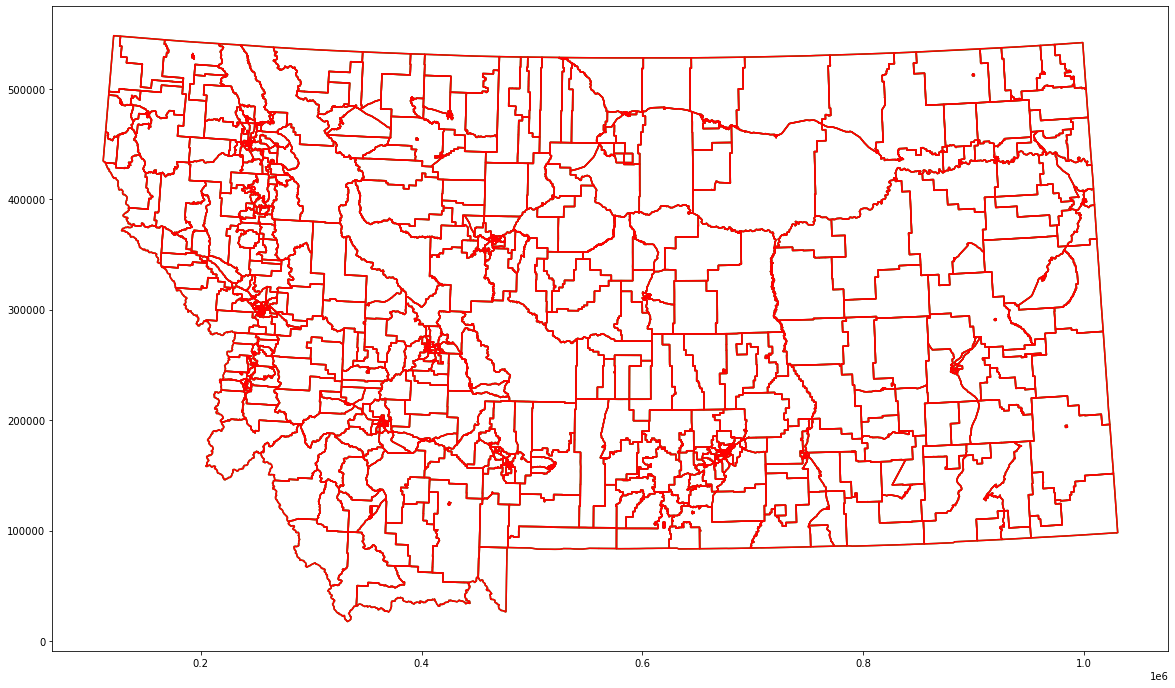

In [45]:
ax = mt_shp.boundary.plot(figsize=(20,20),color="green")
vest_mt_20.boundary.plot(figsize=(20,20),ax=ax,color="red")

In [46]:
mt_shp["join_col"]=mt_shp['COUNTYFP10']+mt_shp['NAME']
mt_shp

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry,join_col
0,000001,#1 Precinct - West,27,14,CJI ELE GYM,Liberty,48,30,051,2010 CENSUS GIS DATA,2012-07-31,4362,1 PREC,26,277799.765292,1.780197e+09,"POLYGON ((470897.374 529015.330, 471296.683 52...",051#1 Precinct - West
1,000001,1-HERON-HD13,13,7,HERON COMMUNITY CENTER,Sanders,35,30,089,COUNTY GIS DATA,2018-10-23,3750,#1,45,89108.059261,2.808293e+08,"POLYGON ((114102.250 461041.840, 114155.020 46...",0891-HERON-HD13
2,000001,1 WESTBY,34,17,WESTBY COMMUNITY HALL,Sheridan,34,30,091,DIGITIZED FROM COUNTY MAP,2019-06-21,4518,1_PREC,46,152033.377796,7.430864e+08,"POLYGON ((998562.006 541713.323, 998580.694 54...",0911 WESTBY
3,000001,COLUMBUS PRECINCT 1,57,29,STILLWATER PAVILLION,Stillwater,32,30,095,COUNTY GIS DATA,2019-08-01,2337,PREC_1,48,210565.225728,9.073550e+08,"POLYGON ((616112.063 176124.484, 616516.128 17...",095COLUMBUS PRECINCT 1
4,000001,FORT BENTON 1,27,14,FORT BENTON ELEMENTARY,Chouteau,19,30,015,DIGITIZED FROM COUNTY MAP,2018-09-18,1596,PCT_01,08,109711.564255,4.525434e+08,"POLYGON ((518671.300 403468.700, 518742.000 40...",015FORT BENTON 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,091RsE,RATTLSNK 91E,91,46,RATTLESNAKE SCHOOL,Missoula,4,30,063,COUNTY GIS DATA,2017-12-08,0101,RTSK91E,32,38610.036938,4.614562e+07,"MULTIPOLYGON (((269038.527 311285.230, 269069....",063RATTLSNK 91E
662,091RsW,RATTLSNK 91W,91,46,RATTLESNAKE SCHOOL,Missoula,4,30,063,COUNTY GIS DATA,2017-12-08,0102,RTSK91W,32,63995.590427,8.861097e+07,"POLYGON ((260921.486 320735.884, 261328.405 32...",063RATTLSNK 91W
663,098CSP,CSPORTER 98,98,49,C S PORTER SCHOOL,Missoula,4,30,063,COUNTY GIS DATA,2017-12-08,0072,CSPTR98,32,8405.353040,2.378015e+06,"POLYGON ((254663.592 300078.247, 254780.890 30...",063CSPORTER 98
664,100SJE,ST JOSEPH 100E,100,50,ST JOSEPH SCHOOL,Missoula,4,30,063,COUNTY GIS DATA,2017-12-08,0111,STJ100E,32,5803.940669,1.297146e+06,"POLYGON ((257366.239 299946.499, 257445.832 29...",063ST JOSEPH 100E


In [47]:
join_attempt_shape1 = pd.merge(vest_mt_20,mt_shp,how="outer",on="join_col",indicator=True)
print(join_attempt_shape1["_merge"].value_counts())
join_attempt_shape1.columns

both          657
left_only       9
right_only      9
Name: _merge, dtype: int64


Index(['STATEFP10_x', 'COUNTYFP10_x', 'COUNTY_x', 'NAME_x', 'SOSPRECINC',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20USSRDAI', 'G20USSDBUL',
       'G20HALRROS', 'G20HALDWIL', 'G20GOVRGIA', 'G20GOVDCOO', 'G20GOVLBIS',
       'G20ATGRKNU', 'G20ATGDGRA', 'G20SOSRJAC', 'G20SOSDBEN', 'G20AUDRDOW',
       'G20AUDDMOR', 'G20AUDLROO', 'G20SPIRARN', 'G20SPIDROM', 'G20SPILLEA',
       'geometry_x', 'join_col', 'NUMBER', 'NAME_y', 'HOUSE', 'SENATE',
       'POLLINGPLA', 'COUNTY_y', 'COUNTYCODE', 'STATEFP10_y', 'COUNTYFP10_y',
       'SOURCE', 'LAST_UPDAT', 'PRECINCT_I', 'PRECINCT_C', 'COUNTY_ID',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry_y', '_merge'],
      dtype='object')

In [48]:
join_attempt_shape1[join_attempt_shape1['_merge'] != 'both'][['COUNTY_x','SOSPRECINC','NAME_y','join_col']]

,COUNTY_x,SOSPRECINC,NAME_y,join_col
119,Madison,JEFFERSON ISLAND,NaN,057JEFFERSON ISLAND
190,Cascade,P22B,NaN,013P22B
387,Flathead,None,NaN,NaN
388,Flathead,None,NaN,NaN
389,Lake,None,NaN,NaN
481,Sanders,9-DIXON-HD14,NaN,0899-DIXON-HD14
656,Lake,PAB 1 HD93,NaN,047PAB 1 HD93
658,Lake,PAB 2 HD15,NaN,047PAB 2 HD15
659,Treasure,PRECINCT 1,NaN,103PRECINCT 1
666,NaN,NaN,Precinct 1,103Precinct 1


In [49]:
source_vest_shp_dict = {'057JEFF ISLAND':'057JEFFERSON ISLAND','013P22B.':'013P22B','0899-Dixon-HD14':'0899-DIXON-HD14','047PAB 1_HD93':'047PAB 1 HD93','047PAB 2_HD15':'047PAB 2 HD15','103Precinct 1':'103PRECINCT 1'}
mt_shp["join_col"]=mt_shp["join_col"].map(source_vest_shp_dict).fillna(mt_shp["join_col"])

In [50]:
join_attempt_shape2 = pd.merge(vest_mt_20,mt_shp,how="outer",on="join_col",indicator=True)
print(join_attempt_shape2["_merge"].value_counts())
join_attempt_shape2

both          663
left_only       3
right_only      3
Name: _merge, dtype: int64


,STATEFP10_x,COUNTYFP10_x,COUNTY_x,NAME_x,SOSPRECINC,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRDAI,G20USSDBUL,...,COUNTYFP10_y,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry_y,_merge
0,30,063,Missoula,Bonner 89,BONNER 89,93.0,112.0,2.0,105.0,109.0,...,063,COUNTY GIS DATA,2017-12-08,0065,BONN89,32,24590.269657,2.350447e+07,"POLYGON ((263282.638 302561.711, 263354.429 30...",both
1,30,063,Missoula,Bonner 92,BONNER 92,715.0,797.0,42.0,653.0,894.0,...,063,COUNTY GIS DATA,2017-12-08,0066,BONN92,32,75142.579778,2.090535e+08,"POLYGON ((270253.436 315619.189, 270300.218 31...",both
2,30,063,Missoula,C S Porter 98,CSPORTER 98,726.0,1218.0,76.0,677.0,1342.0,...,063,COUNTY GIS DATA,2017-12-08,0072,CSPTR98,32,8405.353040,2.378015e+06,"POLYGON ((254663.592 300078.247, 254780.890 30...",both
3,30,063,Missoula,Chief Charlo 90,CHIEF CHARLO 90,550.0,895.0,46.0,542.0,964.0,...,063,COUNTY GIS DATA,2017-12-08,0067,CHIEF90,32,10928.843092,3.815127e+06,"POLYGON ((255159.172 296324.566, 255152.862 29...",both
4,30,063,Missoula,Clinton 89,CLINTON 89,313.0,203.0,19.0,306.0,229.0,...,063,COUNTY GIS DATA,2017-12-08,0068,CLIN89,32,92158.646525,2.455595e+08,"POLYGON ((270340.860 296203.465, 270500.256 29...",both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,30,007,Broadwater,Precinct 1,PRECINCT 1,681.0,205.0,15.0,667.0,239.0,...,007,2010 CENSUS GIS DATA,2012-07-31,5451,PREC_1,04,125074.686978,5.688999e+08,"POLYGON ((425113.429 260287.247, 425523.883 26...",both
665,30,017,Custer,Knowlton,KNOWLTON SCH,39.0,3.0,1.0,38.0,4.0,...,017,2010 CENSUS GIS DATA,2019-08-19,5106,13-37,09,198831.869768,1.016942e+09,"POLYGON ((926330.045 266303.945, 926350.138 26...",both
666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,029,COUNTY GIS DATA,2017-12-08,None,None,15,85442.868939,3.035640e+08,"POLYGON ((280925.736 450294.106, 281044.601 44...",right_only
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,029,COUNTY GIS DATA,2017-12-08,None,None,15,391586.218151,3.494127e+09,"POLYGON ((282315.447 467940.184, 282135.231 46...",right_only


In [51]:
join_attempt_shape2[join_attempt_shape2['_merge'] != 'both'][['COUNTY_x','SOSPRECINC','NAME_y','join_col']]

,COUNTY_x,SOSPRECINC,NAME_y,join_col
387,Flathead,None,NaN,NaN
388,Flathead,None,NaN,NaN
389,Lake,None,NaN,NaN
666,NaN,NaN,NA,029NA
667,NaN,NaN,NA,029NA
668,NaN,NaN,NA,047NA


In [52]:
#print(vest_mt_20.iloc[[387,388,662]])
vest_mt_20.at[387,'join_col'] = 'FLATHEAD-1'
vest_mt_20.at[388,'join_col'] = 'FLATHEAD-2'
vest_mt_20.at[662,'join_col'] = 'LAKE-1'
print(vest_mt_20.iloc[[387,388,662]])

    STATEFP10 COUNTYFP10    COUNTY NAME SOSPRECINC  G20PRERTRU  G20PREDBID  \
387        30        029  Flathead   NA       None           0           0   
388        30        029  Flathead   NA       None           0           0   
662        30        047      Lake   NA       None           0           0   

     G20PRELJOR  G20USSRDAI  G20USSDBUL  ...  G20SOSRJAC  G20SOSDBEN  \
387           0           0           0  ...           0           0   
388           0           0           0  ...           0           0   
662           0           0           0  ...           0           0   

     G20AUDRDOW  G20AUDDMOR  G20AUDLROO  G20SPIRARN  G20SPIDROM  G20SPILLEA  \
387           0           0           0           0           0           0   
388           0           0           0           0           0           0   
662           0           0           0           0           0           0   

                                              geometry    join_col  
387  POLYGON

In [53]:
#mt_shp.iloc[437:440]
mt_shp.at[437,'join_col'] = 'FLATHEAD-1'
mt_shp.at[438,'join_col'] = 'LAKE-1'
mt_shp.at[439,'join_col'] = 'FLATHEAD-2'
mt_shp.iloc[437:440]

,NUMBER,NAME,HOUSE,SENATE,POLLINGPLA,COUNTY,COUNTYCODE,STATEFP10,COUNTYFP10,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry,join_col
437,0000NA,NA,10,5,NA,Flathead,7,30,029,COUNTY GIS DATA,2017-12-08,None,None,15,85442.868939,3.035640e+08,"POLYGON ((280925.736 450294.106, 281044.601 44...",FLATHEAD-1
438,0000NA,NA,12,6,NA,Lake,15,30,047,COUNTY GIS DATA,2018-03-01,None,None,24,164611.557129,3.687516e+08,"POLYGON ((261696.070 421316.430, 261720.650 42...",LAKE-1
439,0000NA,NA,15,8,NA,Flathead,7,30,029,COUNTY GIS DATA,2017-12-08,None,None,15,391586.218151,3.494127e+09,"POLYGON ((282315.447 467940.184, 282135.231 46...",FLATHEAD-2


In [54]:
final_merge = pd.merge(vest_mt_20,mt_shp,how="outer",on="join_col",indicator="final_merge")
print(final_merge["final_merge"].value_counts())
final_merge

both          666
left_only       0
right_only      0
Name: final_merge, dtype: int64


,STATEFP10_x,COUNTYFP10_x,COUNTY_x,NAME_x,SOSPRECINC,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRDAI,G20USSDBUL,...,COUNTYFP10_y,SOURCE,LAST_UPDAT,PRECINCT_I,PRECINCT_C,COUNTY_ID,SHAPE_Leng,SHAPE_Area,geometry_y,final_merge
0,30,063,Missoula,Bonner 89,BONNER 89,93,112,2,105,109,...,063,COUNTY GIS DATA,2017-12-08,0065,BONN89,32,24590.269657,2.350447e+07,"POLYGON ((263282.638 302561.711, 263354.429 30...",both
1,30,063,Missoula,Bonner 92,BONNER 92,715,797,42,653,894,...,063,COUNTY GIS DATA,2017-12-08,0066,BONN92,32,75142.579778,2.090535e+08,"POLYGON ((270253.436 315619.189, 270300.218 31...",both
2,30,063,Missoula,C S Porter 98,CSPORTER 98,726,1218,76,677,1342,...,063,COUNTY GIS DATA,2017-12-08,0072,CSPTR98,32,8405.353040,2.378015e+06,"POLYGON ((254663.592 300078.247, 254780.890 30...",both
3,30,063,Missoula,Chief Charlo 90,CHIEF CHARLO 90,550,895,46,542,964,...,063,COUNTY GIS DATA,2017-12-08,0067,CHIEF90,32,10928.843092,3.815127e+06,"POLYGON ((255159.172 296324.566, 255152.862 29...",both
4,30,063,Missoula,Clinton 89,CLINTON 89,313,203,19,306,229,...,063,COUNTY GIS DATA,2017-12-08,0068,CLIN89,32,92158.646525,2.455595e+08,"POLYGON ((270340.860 296203.465, 270500.256 29...",both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,30,031,Gallatin,69A,PCT 69A,1372,532,58,1298,660,...,031,COUNTY GIS DATA,2018-09-27,0151,69A,16,212991.003110,7.934300e+08,"POLYGON ((457923.569 217011.789, 458325.037 21...",both
662,30,047,Lake,NA,None,0,0,0,0,0,...,047,COUNTY GIS DATA,2018-03-01,None,None,24,164611.557129,3.687516e+08,"POLYGON ((261696.070 421316.430, 261720.650 42...",both
663,30,007,Broadwater,Precinct 13,PRECINCT 13,857,166,25,838,213,...,007,2010 CENSUS GIS DATA,2012-07-31,5454,PREC_13,04,212002.525263,1.148313e+09,"POLYGON ((423894.239 226633.240, 425686.070 22...",both
664,30,007,Broadwater,Precinct 1,PRECINCT 1,681,205,15,667,239,...,007,2010 CENSUS GIS DATA,2012-07-31,5451,PREC_1,04,125074.686978,5.688999e+08,"POLYGON ((425113.429 260287.247, 425523.883 26...",both


In [55]:
print(final_merge.columns)

Index(['STATEFP10_x', 'COUNTYFP10_x', 'COUNTY_x', 'NAME_x', 'SOSPRECINC',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20USSRDAI', 'G20USSDBUL',
       'G20HALRROS', 'G20HALDWIL', 'G20GOVRGIA', 'G20GOVDCOO', 'G20GOVLBIS',
       'G20ATGRKNU', 'G20ATGDGRA', 'G20SOSRJAC', 'G20SOSDBEN', 'G20AUDRDOW',
       'G20AUDDMOR', 'G20AUDLROO', 'G20SPIRARN', 'G20SPIDROM', 'G20SPILLEA',
       'geometry_x', 'join_col', 'NUMBER', 'NAME_y', 'HOUSE', 'SENATE',
       'POLLINGPLA', 'COUNTY_y', 'COUNTYCODE', 'STATEFP10_y', 'COUNTYFP10_y',
       'SOURCE', 'LAST_UPDAT', 'PRECINCT_I', 'PRECINCT_C', 'COUNTY_ID',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry_y', 'final_merge'],
      dtype='object')


In [56]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    634
True      32
dtype: int64


1) For Swan 92 difference in area is 0.12184738617969963
2) For Alder Precinct 1, Ward 2 difference in area is 0.10442826678774657
3) For KIRBY DECKER difference in area is 0.25869857522042894
4) For Spring Creek difference in area is 0.11207436672250733
5) For Sand Springs difference in area is 0.3768205562619845
6) For Precinct 17 difference in area is 0.1233779026277029
7) For Lavina difference in area is 0.5339707751821668
8) For Precinct 2 difference in area is 0.5987685620171234
9) For BUSBY difference in area is 0.43123062294648745
10) For Precinct 38 difference in area is 0.23790335492623793
11) For Precinct 4 difference in area is 0.48790002693967566
12) For Precinct 4 difference in area is 0.10982698750703612
13) For Precinct 4 difference in area is 0.2313858333965946
14) For Precinct 5 difference in area is 0.48626826121879996
15) For Precinct 5 - Plentywood Rural West difference in area is 0.14987000280859636
16) For 59A difference in area is 0.15469787142165575
17) For 59B

C:\Users\davey\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


22) For Precinct 8 difference in area is 0.15688516989314916
23) For DAY1 difference in area is 2.2565950523259017
24) For NA difference in area is 0.13864158289466985
25) For POL2 difference in area is 0.14473184266846315
26) For POL3 difference in area is 0.1752600284046885
27) For STI2 difference in area is 0.11174639787559891
28) For SWA2 difference in area is 0.21721459702651114
29) For 59A difference in area is 0.1300644829116173
30) For 3-TROUT CREEK - HD13 difference in area is 0.1169059750634778
31) For Precinct 20 difference in area is 0.2409420506022483
32) For Precinct 30 difference in area is 0.13530254822582527
33) For Precinct 1 difference in area is 0.10173848064854328
34) For Precinct 26 difference in area is 0.6277924808057457
35) For Precinct 10 difference in area is 0.3173201448447489
36) For Precinct 20 difference in area is 0.12071449341335248
37) For Precinct 11 difference in area is 0.11338342288349332
38) For Precinct 17 difference in area is 0.1574197311874577

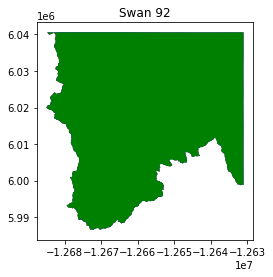

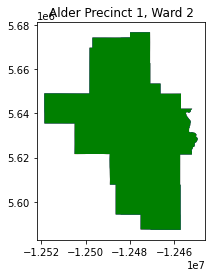

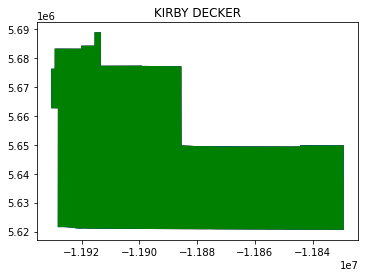

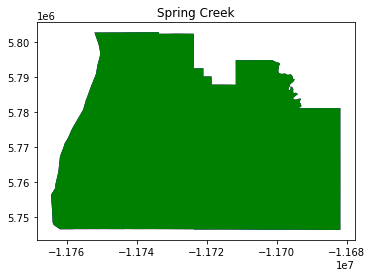

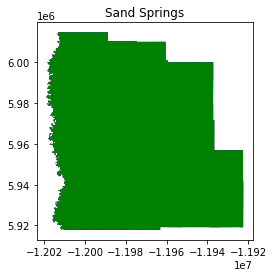

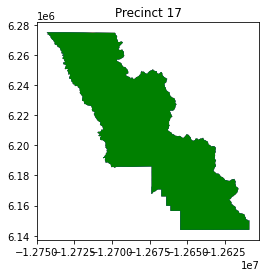

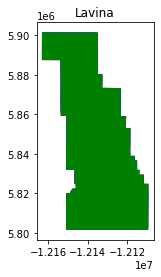

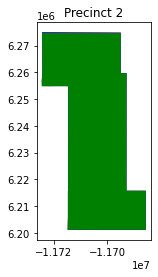

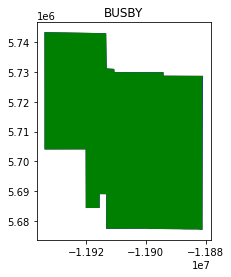

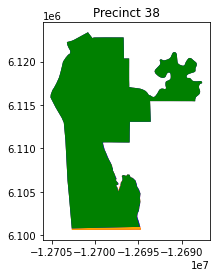

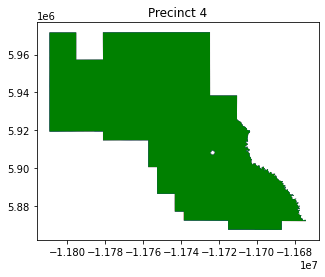

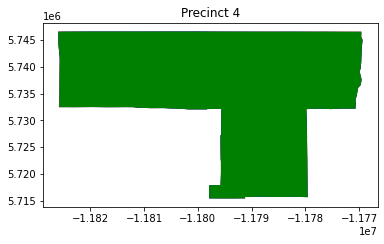

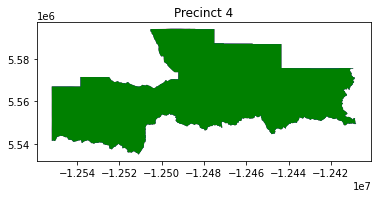

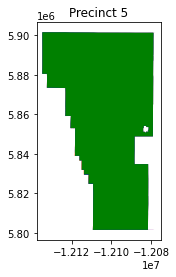

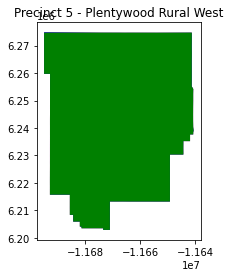

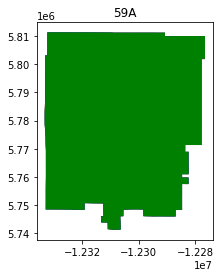

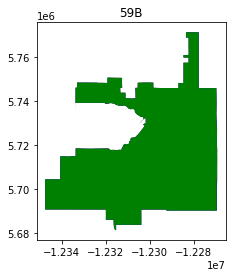

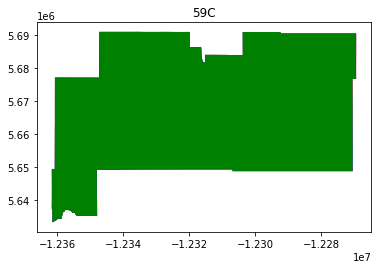

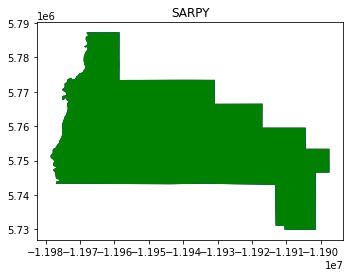

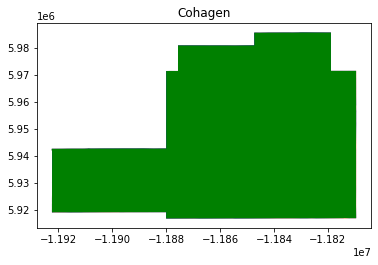

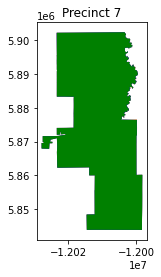

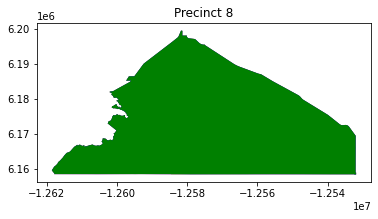

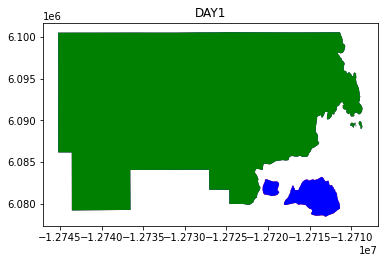

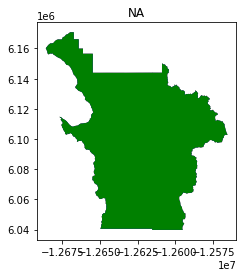

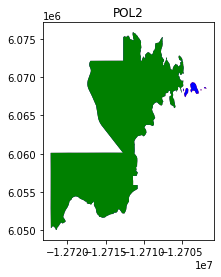

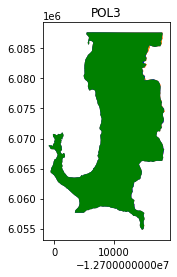

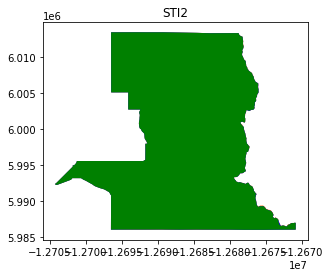

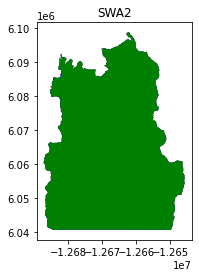

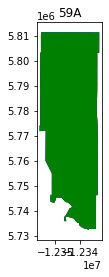

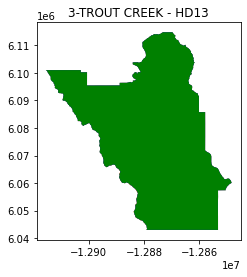

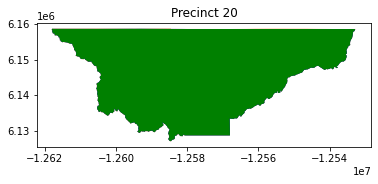

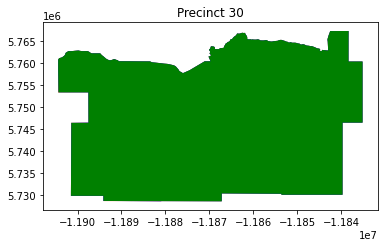

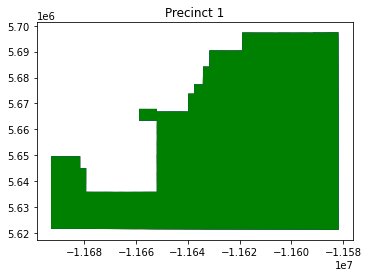

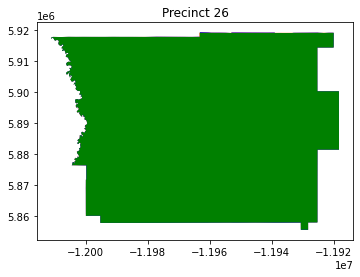

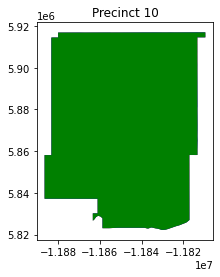

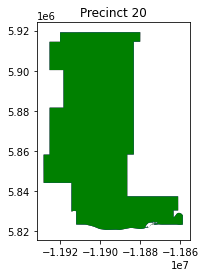

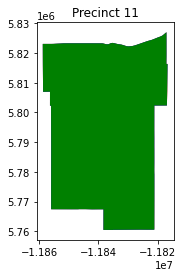

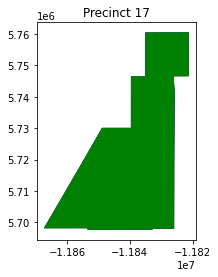

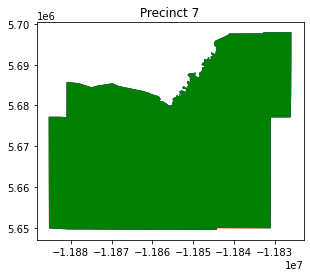

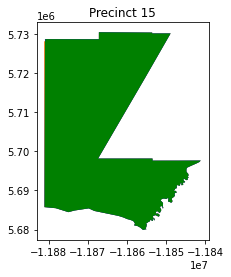

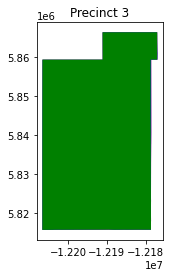

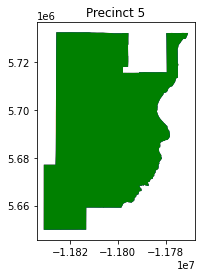

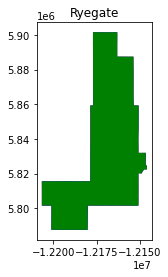

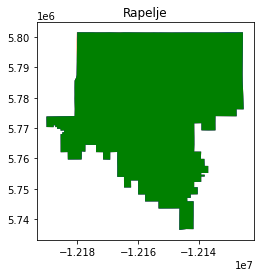

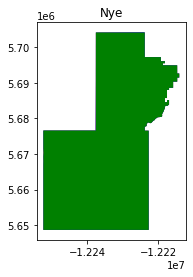

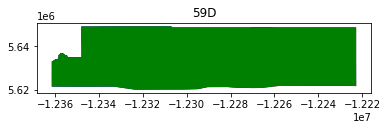

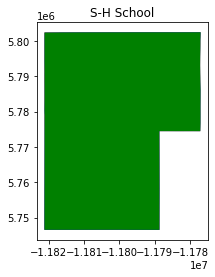

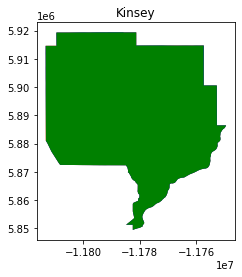

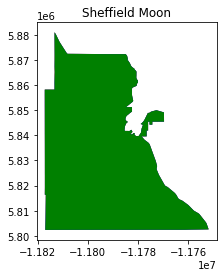

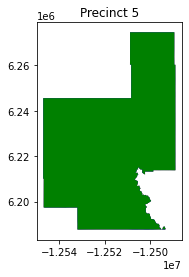

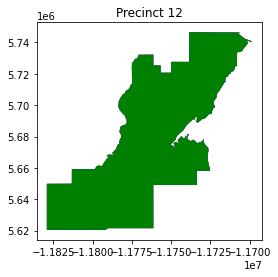

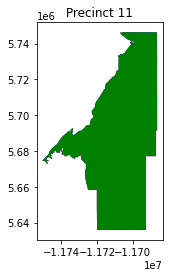

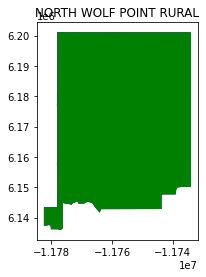

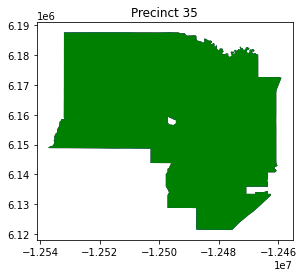

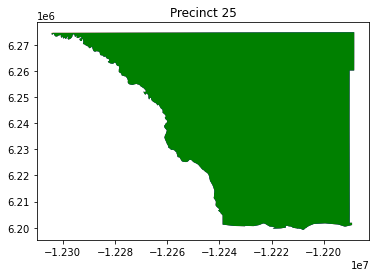

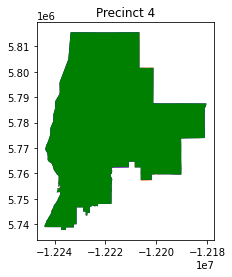

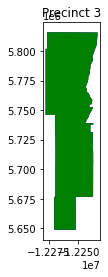

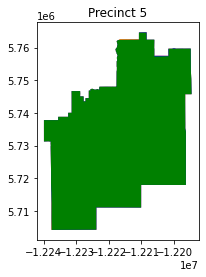

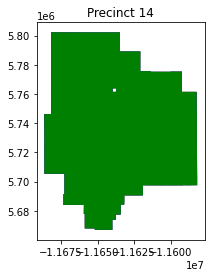

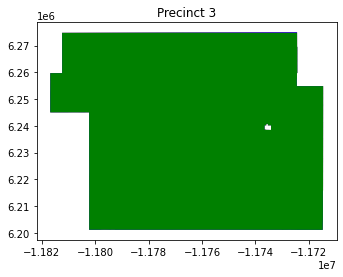

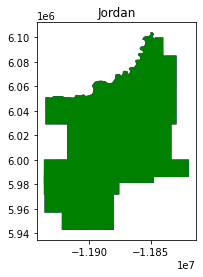

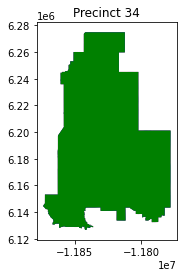

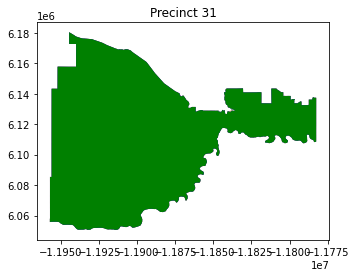

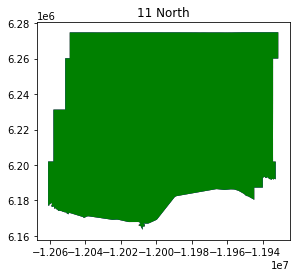

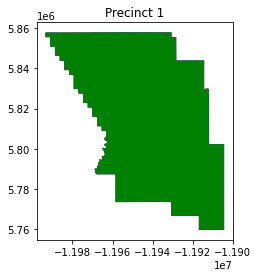

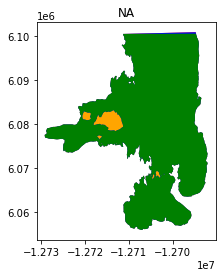

In [57]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,3]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [58]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")



(666, 1)
29 precincts w/ a difference of 0 km^2
571 precincts w/ a difference between 0 and .1 km^2
58 precincts w/ a difference between .1 and .5 km^2
5 precincts w/ a difference between .5 and 1 km^2
1 precincts w/ a difference between 1 and 2 km^2
2 precincts w/ a difference between 2 and 5 km^2
0 precincts w/ a difference greater than 5 km^2
